In [1]:
import pandas as pd
import numpy as np
from pandas import Series

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import f1_score, plot_confusion_matrix, accuracy_score, recall_score, precision_score


%matplotlib inline

# Обработка пропусков

In [2]:
data = pd.read_csv('train.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   client_id         73799 non-null  int64 
 1   education         73492 non-null  object
 2   sex               73799 non-null  object
 3   age               73799 non-null  int64 
 4   car               73799 non-null  object
 5   car_type          73799 non-null  object
 6   decline_app_cnt   73799 non-null  int64 
 7   good_work         73799 non-null  int64 
 8   bki_request_cnt   73799 non-null  int64 
 9   home_address      73799 non-null  int64 
 10  work_address      73799 non-null  int64 
 11  income            73799 non-null  int64 
 12  foreign_passport  73799 non-null  object
 13  default           73799 non-null  int64 
dtypes: int64(9), object(5)
memory usage: 7.9+ MB


In [3]:
# визуализация
# fig, ax = plt.subplots(figsize=(20,12))
# sns_heatmap = sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [4]:
def preproc_na_df(df):
    # fill null in education
    most_common = df['education'].mode()
    df['education'].fillna(most_common[0], inplace=True)
    return df

In [5]:

data = preproc_na_df(data)

# Рассмотрение числовых, бинарных и категориальных признаков

In [6]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport' ]
cat_cols = ['education', 'home_address', 'work_address']
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']

#логарифмируем числовые признаки
#for col in num_cols:
#    data[col] = data[col].apply(lambda x: np.log1p(x))

# удаляем client_id
data.drop('client_id', axis=1, inplace=True)



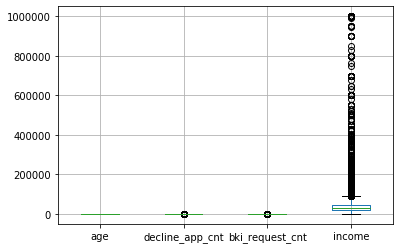

In [7]:
data[num_cols].boxplot()

In [8]:
def has_outliers(column, df=data):

    q25, q75 = np.percentile(df[column], [25, 75], axis=0)
    iqr = q75-q25
    lower_bound = q25 - 1.5*iqr
    upper_bound = q75 + 1.5*iqr
    
#     print('---------------------------')
#     print('Границы выбросов: ', lower_bound, ', ', upper_bound)
#     print('---------------------------')

    ok_values_cnt = (df[column].loc[df[column].between(
        lower_bound, upper_bound)]).count()
    outliers_cnt = df[column].count() - ok_values_cnt

    print('---------------------------')
    print('Количество выбросов', outliers_cnt)
    print('---------------------------')

In [9]:
'''return new df without outliers in column'''


def del_outliers_for_column(column, df):
    q25, q75 = np.percentile(df[column], [25, 75], axis=0)
    iqr = q75-q25
    lower_bound = q25 - 1.5*iqr
    upper_bound = q75 + 1.5*iqr

    df_no_outliers = df.loc[df[column].between(lower_bound, upper_bound)]
    
    # print(len(df_no_outliers))
    # display(df_no_outliers)
    return df_no_outliers

In [10]:
for col in num_cols:
    print(col.upper())
    has_outliers(col)
    print('LOGARITHM')
    has_outliers(col, np.log1p(data[num_cols]))


AGE
---------------------------
Количество выбросов 0
---------------------------
LOGARITHM
---------------------------
Количество выбросов 0
---------------------------
DECLINE_APP_CNT
---------------------------
Количество выбросов 12585
---------------------------
LOGARITHM
---------------------------
Количество выбросов 12585
---------------------------
BKI_REQUEST_CNT
---------------------------
Количество выбросов 1755
---------------------------
LOGARITHM
---------------------------
Количество выбросов 9
---------------------------
INCOME
---------------------------
Количество выбросов 4695
---------------------------
LOGARITHM
---------------------------
Количество выбросов 1767
---------------------------


## выводы про выбросы

применять очистку от выбросов будем на логарифмированных числовых данных.

age - не содержит выбросов

decline_cnt_app - более 75% значений =0, остальные считатются выбросами. убирать их из модели не будем
ВОЗМОЖНО, в дальнейшем заменим на бинарный признак "ЕСТЬ/НЕТ отказы"

bki_request_cnt - удаляем выбросы, после логарифмирования - так их будем меньше (9 шт против 1755). смотрим на модель

income - попробуем удалить выбросы после логарифмирования (1767 шт против 4695)


# Логарифмируем числовые параметры

In [11]:
for col in num_cols:
    data[col] = data[col].apply(lambda x: np.log1p(x))



In [12]:
data.sample(4)

,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
4237,UGR,M,3.295837,Y,N,0.693147,0,1.386294,2,3,10.043293,N,0
7402,SCH,M,3.258097,N,N,0.000000,0,0.000000,2,3,10.596660,N,0
50462,SCH,F,3.737670,Y,Y,0.000000,0,0.693147,2,3,10.308986,N,0
48151,GRD,M,3.688879,Y,N,0.000000,0,1.098612,2,3,10.463132,N,0


# Удаляем выбросы для признаков

In [13]:
# data = del_outliers_for_column('bki_request_cnt', data)

# data = del_outliers_for_column('income', data)

data.shape

(73799, 13)

In [14]:
def lookup_on_num_column(df, col_name):
    plt.figure(figsize=(30,30))
#     sns.displot(x = col_name, data=df)
    plt.show()
    sns.histplot(data=df[col_name])

<Figure size 2160x2160 with 0 Axes>

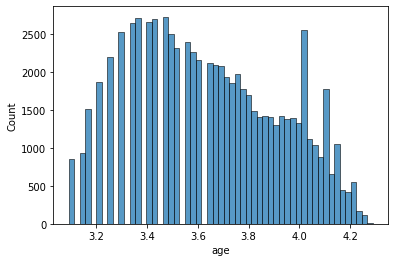

<Figure size 2160x2160 with 0 Axes>

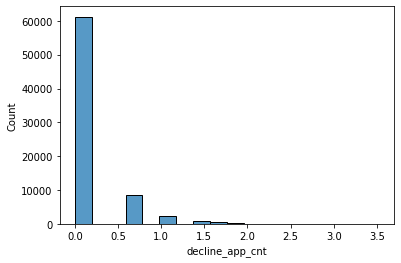

<Figure size 2160x2160 with 0 Axes>

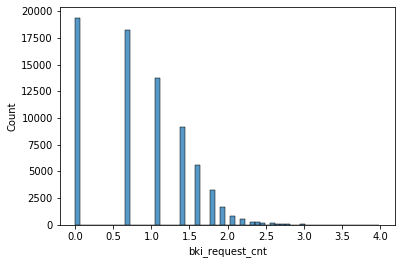

<Figure size 2160x2160 with 0 Axes>

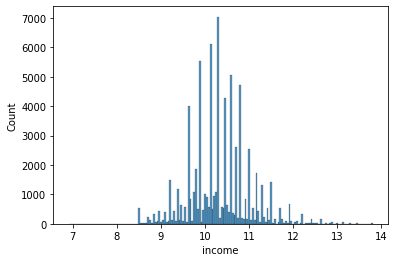

In [15]:
for col in num_cols:
    lookup_on_num_column(data, col)


In [16]:
# for i in num_cols:
#     plt.figure()
#     sns.distplot(data[i][data[i] > 0].dropna(), kde = False, rug=False)
#     plt.title(i)
#     plt.show()

In [17]:
def boxplot_for_numcols(df, col_name, hue_col=None):
    plt.figure()
    sns.boxplot(x=df[hue_col], y=df[col_name])
    plt.show

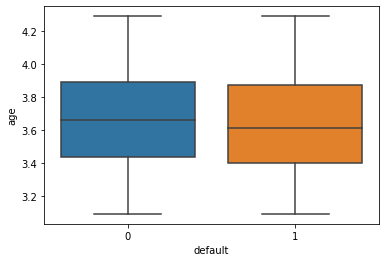

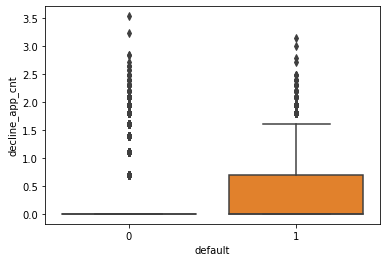

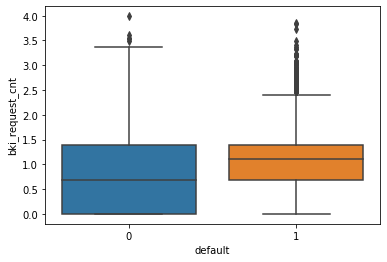

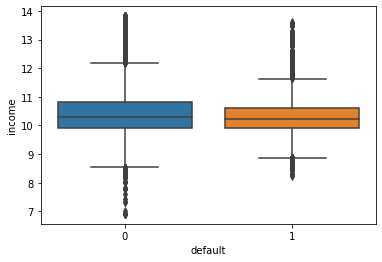

In [18]:
for column in num_cols:
    boxplot_for_numcols(data, column, 'default')

In [19]:
# уточняем значения медианы, а то на графике не видно
#print('MEAN for decline_app_cnt:\n', data.groupby(by='default')['decline_app_cnt'].mean())
#print('MEAN for income:\n', data.groupby(by='default')['income'].mean())


# Корреляция между числовыми признаками

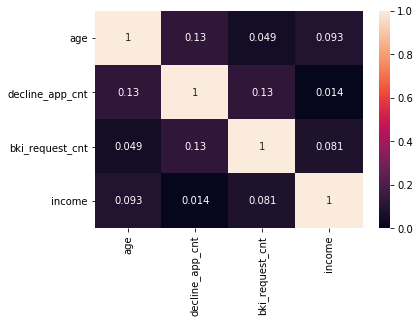

In [20]:
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1, annot=True)

##  Вывод про корреляцию

Видим, что абсолютные значения корреляции не большие (макс - 0.13) - т.е признаки можем считать независимыми, и добавлять их в модель все

# Построение ANOVA-f метрики для оценки значимости числовых признаков

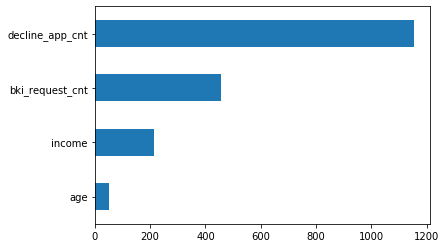

In [21]:
imp_num = Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

### Вывод

признаки отсортированы по значению метрики - более высокое значение метрики соответствует большему влияну признака на оцениваемое значение

# Работа с бинарными признаками - перекодировка в числовые (0, 1)

In [22]:
# TEST
# label_encoder = LabelEncoder()
# mapped_sex = pd.Series(label_encoder.fit_transform(data['sex']))
# print(dict(enumerate(label_encoder.classes_)))


In [23]:
label_encoder = LabelEncoder()


for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

In [24]:
#for l in label_encoder.classes_:
#    print(dict(enumerate(l)))

### Категориальные признаки тоже надо сделать числовыми

In [25]:
print(data['education'].unique())
data['education'] = label_encoder.fit_transform(data['education'])
print(dict(enumerate(label_encoder.classes_)))

['SCH' 'GRD' 'UGR' 'PGR' 'ACD']
{0: 'ACD', 1: 'GRD', 2: 'PGR', 3: 'SCH', 4: 'UGR'}


## Значимость категориальных (+бинарных) признаков

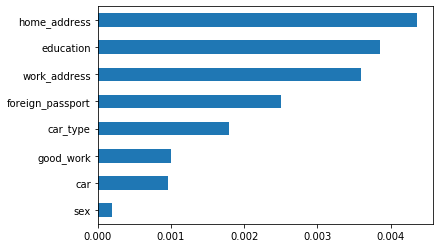

In [26]:
imp_cat = Series(mutual_info_classif(
    data[bin_cols + cat_cols], data['default'], discrete_features=True), index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

### Вывод

признаки отсортированы по значению метрики - более высокое значение метрики соответствует большему влияну признака на оцениваемое значение

## One-hot encoding для категориальных переменных

In [27]:
# one-hot encoding для категориальных переменных
X_cat = OneHotEncoder(sparse = False).fit_transform(data[cat_cols].values)

In [28]:
X_cat.shape

(73799, 11)

# Стандартизация числовых переменных
##### Чтоб среднее 0, а отклонение 1


# стандартизацию будем делать после разбиения датасета на тренировочный и тестовый

In [29]:
#X_num = StandardScaler().fit_transform(data[num_cols].values)

# убедились, что среднее 0, отклонение 1
#print(X_num.mean(axis=0))
#print(X_num.std(axis=0))

#X_num.shape

# Собираем вместе все преобразованные части датасета

###### числовые - логарифмированы
###### категориальные - преобразованы в числовые, сделан one-hot (dummies)
###### бинарные

для признаков bki_reqiest_cnt, income удалены выбросы, которые были после логарифмирования

In [30]:
# Объединяем

#X = np.hstack([X_num, data[bin_cols].values, X_cat])
X = np.hstack([data[num_cols], data[bin_cols].values, X_cat])

Y = data['default'].values

# Разбиваем выборку на учебную и тестовую

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

## Стандартизуем числовые признаки отдельно тренировочной, отдельно тестовой выборок

In [32]:
scaler = StandardScaler()

X_train[:,:4] = scaler.fit_transform(X_train[:,:4]).copy()

X_test[:,:4] = scaler.transform(X_test[:,:4])


In [33]:
#X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [34]:
model = LogisticRegression( max_iter=300)


model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#f1 = f1_score(y_test, y_pred)
#print("f1 ", f1)

# tn, fp, fn, tp 
#confusion_matrix(y_test, y_pred).ravel()

# Метрики

In [35]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
Sp = tn / (tn+fp)
# Se = tp / (tp+fn)
# Re = tp / (tp+fn)
# Pr = tp / (tp+fp)
# Ac = (tn+tp) / (tp+tn+fp+fn)
# print('Acc=%.4f.  Pr=%.4f.  Re=%.4f.  Se=%.4f.  Sp=%.4f' % (Ac , Pr , Re , Se , Sp))
print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))
print('Precision: %.4f' % precision_score(y_test, y_pred))
print('Recall: %.4f' % recall_score(y_test, y_pred))
print('Specifity: %.4f' % Sp)
print('F1: %.4f' % f1_score(y_test, y_pred))

Accuracy: 0.8762
Precision: 0.5000
Recall: 0.0027
Specifity: 0.9996
F1: 0.0054


In [36]:
# все числовые прологарифмированы, удалили выбросы bki_request_cnt, income
Accuracy: 0.8771
Precision: 0.2857
Recall: 0.0023
Specifity: 0.9992
F1: 0.0045

# все числовые прологарифмировали, удалили выбросы для bki_request_cnt
Accuracy: 0.8740
Precision: 0.5625
Recall: 0.0048
Specifity: 0.9995
F1: 0.0096

# все числовые прологарифмировали
Accuracy: 0.8762
Precision: 0.5000
Recall: 0.0027
Specifity: 0.9996
F1: 0.0054

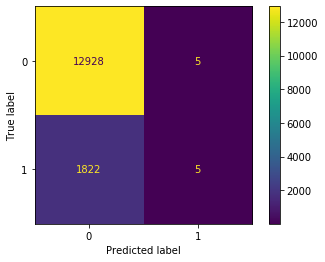

In [37]:
plot_confusion_matrix(model, X_test, y_test)  # doctest: +SKIP
plt.show()

# ROC-AUC

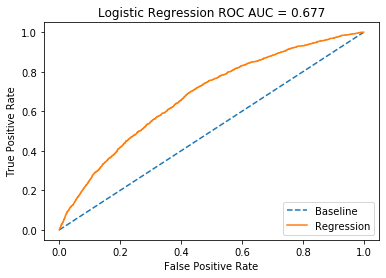

In [38]:
#построение  ROC 
probs = model.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [39]:
confusion_matrix(y_test, y_pred)

array([[12928,     5],
       [ 1822,     5]])

# Подбор гиперпараметров penalty и С

C  [1.00000000e+00 2.78255940e+00 7.74263683e+00 2.15443469e+01
 5.99484250e+01 1.66810054e+02 4.64158883e+02 1.29154967e+03
 3.59381366e+03 1.00000000e+04]
Лучшее Penalty: l1
Лучшее C: 1.0
Best model:
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 200, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Accuracy: 0.8762
Precision: 0.5000
Recall: 0.0027
F1: 0.0054


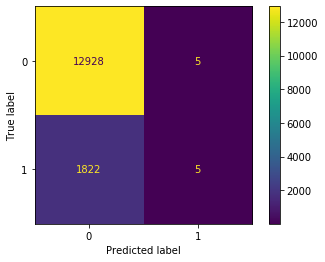

In [40]:
from sklearn.model_selection import GridSearchCV

# import warnings
# warnings.filterwarnings("ignore")

# Добавим типы регуляризации
penalty = ['l1', 'l2']
#penalty = ['l2']



# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)
print('C ', C)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

#model = LogisticRegression()
model = LogisticRegression(solver = 'liblinear', max_iter=200)

model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
gridSearch = GridSearchCV(model, hyperparameters, cv=5, verbose=0)
gridSearch.fit(X_train, y_train)


# View best hyperparameters
print('Лучшее Penalty:', gridSearch.best_estimator_.get_params()['penalty'])
print('Лучшее C:', gridSearch.best_estimator_.get_params()['C'])

best_model = gridSearch.best_estimator_

print('Best model:')
print(best_model.get_params())
y_pred = best_model.predict(X_test)
plot_confusion_matrix(best_model, X_test, y_test)

print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))
print('Precision: %.4f' % precision_score(y_test, y_pred))
print('Recall: %.4f' % recall_score(y_test, y_pred))
print('F1: %.4f' % f1_score(y_test, y_pred))

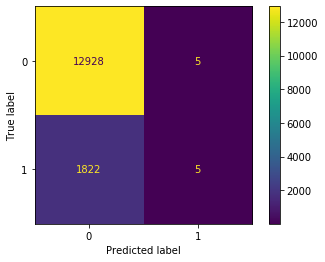

In [41]:
plot_confusion_matrix(best_model, X_test, y_test)

In [42]:
# запускаем GridSearch на небольшом кол-ве итераций max_iter=50 и с достаточно большой дельтой останова tol1e-3
# чтобы получить оптимальные параметры модели в первом приближении
model = LogisticRegression(random_state=42)

iter_ = 50
epsilon_stop = 1e-3

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
##печатаем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))
    ##печатаем метрики
preds = model.predict(X_test)
print('Accuracy: %.4f' % accuracy_score(y_test, preds))
print('Precision: %.4f' % precision_score(y_test, preds))
print('Recall: %.4f' % recall_score(y_test, preds))
print('F1: %.4f' % f1_score(y_test, preds))

	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'l1'
	random_state: 42
	solver: 'liblinear'
	tol: 0.001
	verbose: 0
	warm_start: False
Accuracy: 0.6169
Precision: 0.1897
Recall: 0.6404
F1: 0.2927


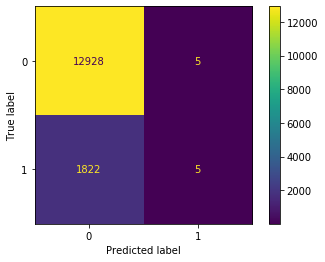

In [43]:
plot_confusion_matrix(best_model, X_test, y_test)

удалены выбросы по income, bki_request_cnt

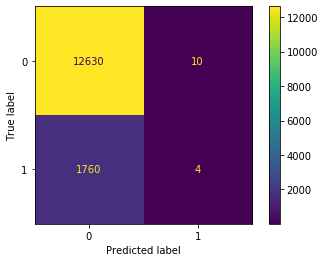

удалены выбросы по  bki_request_cnt

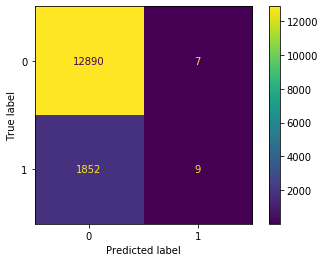

ничего не удалено из выбросов

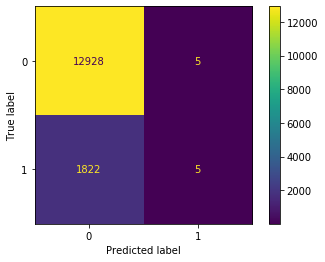